# Customer acquisition model

It describes the process of how new products or services are adopted by consumers. We will build and study the model according the following connected approaches: 
- causal loop model, 
- system dynamics using BPTK, 
- system dynamics using XMILE,
- system archetype study,
- differential equations system and control problem, and
- viability problem


## Causal loop model
The basic structure of the model is illustrated in the following causal loop diagram:

![Customer Acquisition CLD](./images/causal-loop.jpeg)

## System Dynamics using BPTK
Based on the causal loop diagram, we will implement a stock and flow model with the following stocks, flows, converters and constants:

![Customer Acquisition CLD](./images/System-Dynamics.jpeg)

The software for implementing System Dynamics is https://www.transentis.com/resources/business-prototyping-toolkit

In [32]:
# !pip install BPTK-Py

In [33]:
from BPTK_Py import Model
from BPTK_Py import sd_functions as sd

### Set-up the model

In [34]:
model = Model(starttime=1.0,stoptime=60.0, dt=1.0, name="Customer Acquisition SDDSL")

In [35]:
# stocks
customers = model.stock("customers")
potential_customers = model.stock("potential_customers")

In [36]:
#flows
customer_acquisition=model.flow("customer_acquisition")

In [37]:
#converters
acquisition_through_advertising = model.converter("acquisition_through_advertising")
acquisition_through_word_of_mouth = model.converter("acquisition_through_word_of_mouth")
consumers_reached_through_advertising = model.converter("consumers_reached_through_advertising")
consumers_reached_through_word_of_mouth= model.converter("consumers_reached_through_word_of_mouth")
market_saturation = model.converter("market_saturation")

In [38]:
#constants
initial_customers = model.constant("initial_customers") 
initial_potential_customers = model.constant("initial_potential_customers") 
advertising_success = model.constant("advertising_success")
consumers_reached_per_euro = model.constant("consumers_reached_per_ruro")
advertising_budget = model.constant("advertising_budget")
word_of_mouth_success = model.constant("word_of_mouth_success")
contact_rate = model.constant("contact_rate")

In [39]:
#equations
customers.equation = customer_acquisition
potential_customers.equation = -customer_acquisition
customer_acquisition.equation=sd.min(potential_customers,acquisition_through_advertising+acquisition_through_word_of_mouth)
acquisition_through_advertising.equation = advertising_success*consumers_reached_through_advertising
consumers_reached_through_advertising.equation = consumers_reached_per_euro*advertising_budget*(1-market_saturation)
market_saturation.equation = customers/(customers+potential_customers)
acquisition_through_word_of_mouth.equation = word_of_mouth_success*consumers_reached_through_word_of_mouth
consumers_reached_through_word_of_mouth.equation=contact_rate*customers*(1-market_saturation)

In [42]:
#initialize model
customers.initial_value=initial_customers
potential_customers.initial_value=initial_potential_customers
initial_customers.equation = 100.0
initial_potential_customers.equation = 60000.0
advertising_success.equation = 0.1
consumers_reached_per_euro.equation = 100.0
advertising_budget.equation = 100.0
word_of_mouth_success.equation = 0.01
contact_rate.equation = 10.0

### Run de model

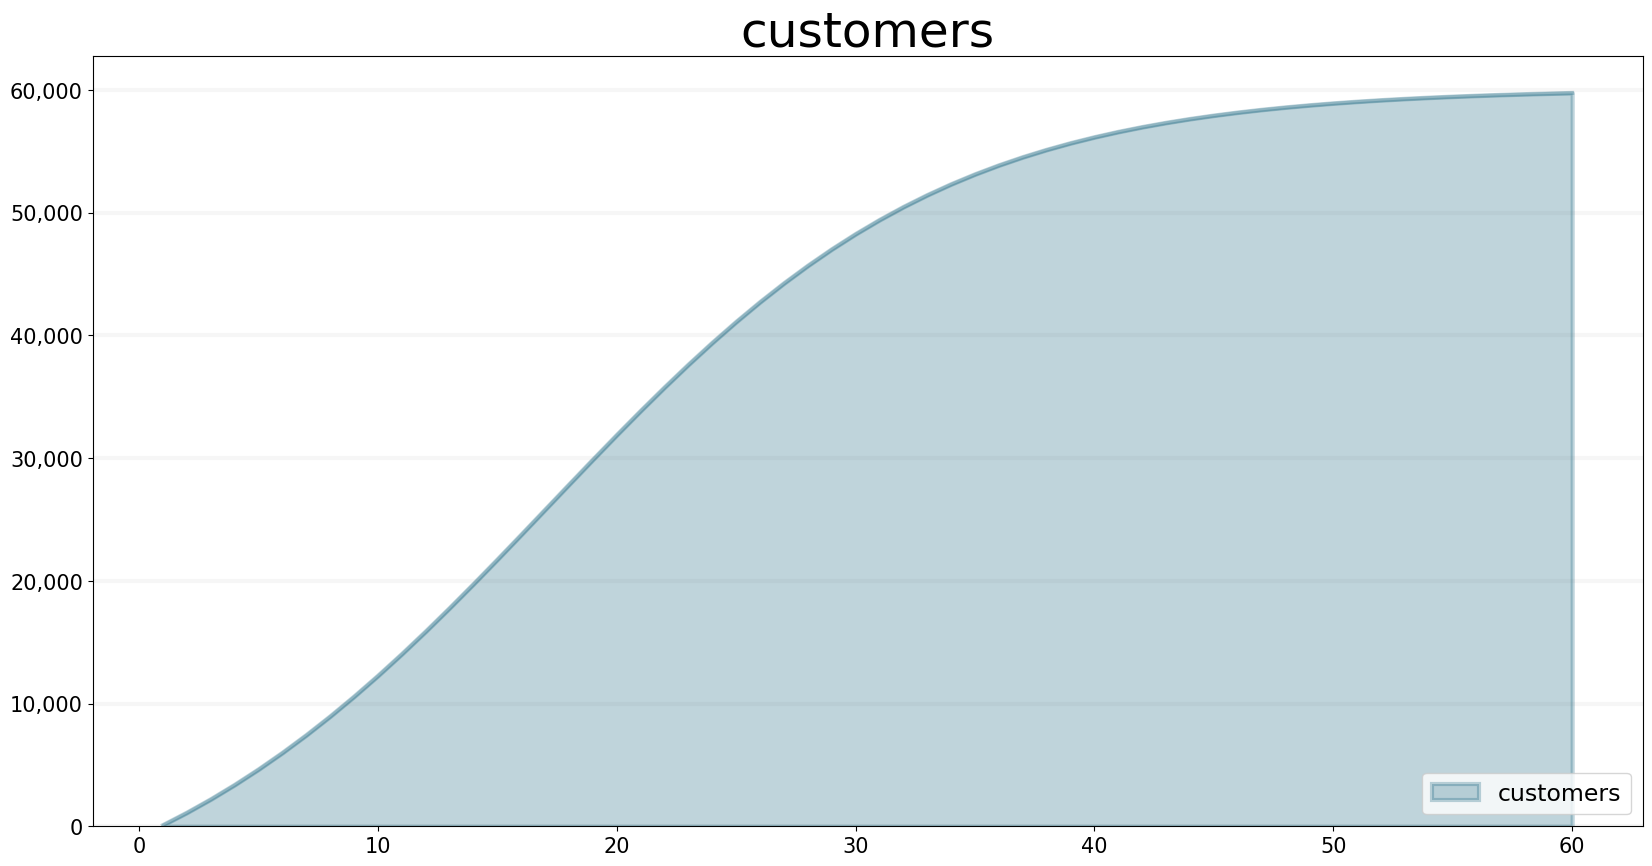

In [43]:
customers.plot()

You can also access the underlying Pandas dataframe:

In [44]:
customers.plot(return_df=True)[1:10]

/var/folders/np/mbq0t3tj2bl4dclfq_32k6km0000gn/T/ipykernel_50647/2717986693.py:1: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  customers.plot(return_df=True)[1:10]


,customers
1.0,100.000000
2.0,1108.319468
3.0,2198.666278
4.0,3373.905957
5.0,4636.217849
6.0,5986.933321
7.0,7426.370906
8.0,8953.675727
9.0,10566.672142
10.0,12261.739886


### Scenario management

In [45]:
scenario_manager={
    "bass_difussion":{
        "model":model,
        "base_constants":{
            "initial_customers" : 0.0,
            "initial_potential_customers" : 60000.0,
            "advertising_success": 0.1,
            "consumers_reached_per_euro" : 100.0,
            "advertising_budget" : 100.0,
            "word_of_mouth_success": 0.01,
            "contact_rate" : 10.0
        }
    }
}

In [46]:
import BPTK_Py
bptk = BPTK_Py.bptk()

In [47]:
bptk.register_scenario_manager(scenario_manager)

In [48]:
bptk.register_scenarios(
    
    scenario_manager="bass_difussion",
    scenarios=
    {
        "base":{
            
        },
        "low_word_of_mouth":{
            "constants":{
                "word_of_mouth_success":0.001
            }
        },
        "high_word_of_mouth":{
            "constants":{
                "word_of_mouth_success":0.1
            }
        },
        "interactive_scenario":{}
        
    }
    

)

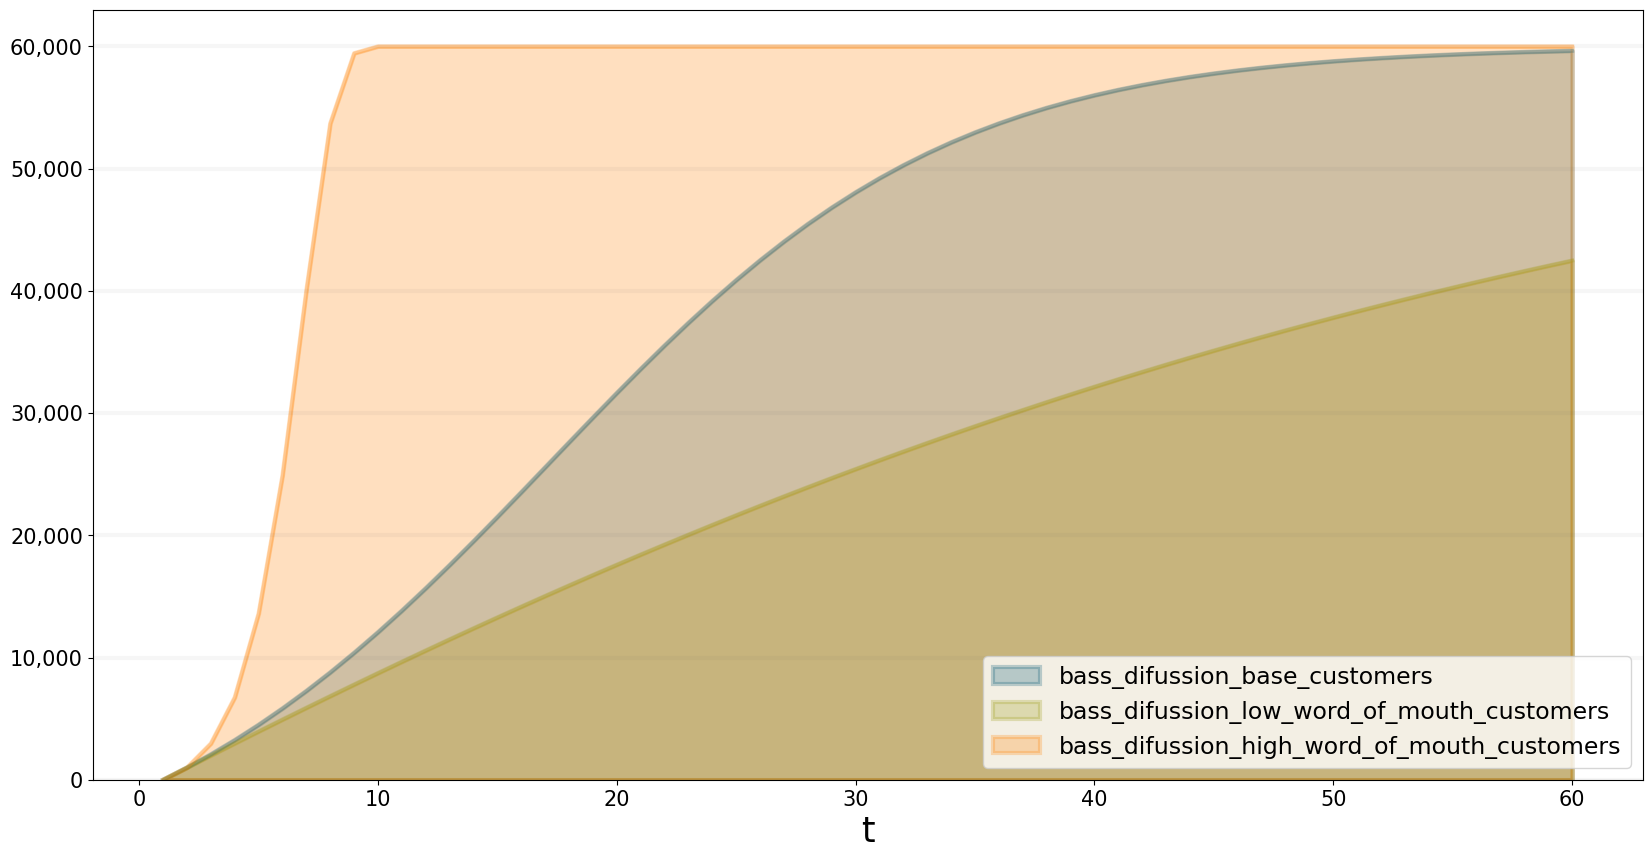

In [49]:
bptk.plot_scenarios(
    scenario_managers=["bass_difussion"],
    scenarios=["base","low_word_of_mouth","high_word_of_mouth"],
    equations=["customers"],
    series_names={
        "sddsl_customer_acquisition_base_customers":"Base",
        "sddsl_customer_acquisition_low_word_of_mouth_customers":"Low Word of Mouth",
        "sddsl_customer_acquisition_high_word_of_mouth_customers":"High Word of Mouth",
    }
)

In [50]:
bptk.get_scenario_names([],format="dict")

{'bass_difussion': ['base',
  'low_word_of_mouth',
  'high_word_of_mouth',
  'interactive_scenario']}

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets

In [52]:
customerTab = widgets.Output()
customerAcquisitionTab = widgets.Output()
scenariosTab = widgets.Output()


tabs = widgets.Tab(children = [customerTab, customerAcquisitionTab,scenariosTab])
tabs.set_title(0, 'Customers')
tabs.set_title(1, 'Customer Acquisition')
tabs.set_title(2, 'Scenarios')
display(tabs)

@interact(word_of_mouth_success=widgets.FloatSlider(
    value=0.01,
    min=0.001,
    max=0.1,
    step=0.001,
    continuous_update=False,
    description='WoM'))

def dashboardWithTabs(word_of_mouth_success):
    scenario= bptk.get_scenario("bass_difussion","interactive_scenario")
    
    scenario.constants["word_of_mouth_success"]=word_of_mouth_success
    bptk.reset_scenario_cache(scenario_manager="bass_difussion",
                                                             scenario="interactive_scenario")



    with customerTab:
        # turn of pyplot's interactive mode to ensure the plot is not created directly
        plt.ioff()
        # clear the widgets output ... otherwise we will end up with a long list of plots, one for each change of settings
        customerTab.clear_output()
        # create the plot, but don't show it yet
        bptk.plot_scenarios(
            scenario_managers=["bass_difussion"],
            scenarios=["interactive_scenario"],
            equations=['customers'],
            title="Customers",
            freq="M",
            x_label="Time",
            y_label="No. of Customers"
            )
        # show the plot
        plt.show()
        # turn interactive mode on again
        plt.ion()

    with customerAcquisitionTab:
        plt.ioff()
        customerAcquisitionTab.clear_output()
        bptk.plot_scenarios(
            scenario_managers=["bass_difussion"],
            scenarios=["interactive_scenario"],
            equations=['customer_acquisition'],
            title="Customer Acquisition",
            freq="M",
            x_label="Time",
            y_label="No. of Customers"
            )
        plt.show()
        plt.ion()
    
    with scenariosTab:
        plt.ioff()
        scenariosTab.clear_output()
        bptk.plot_scenarios(
            scenario_managers=["bass_difussion"],
            scenarios=["base","low_word_of_mouth","high_word_of_mouth","interactive_scenario"],
            equations=["customers"],
            series_names={
                "sddsl_customer_acquisition_base_customers":"Base",
                "sddsl_customer_acquisition_interactive_scenario_customers":"Interactive",
                "sddsl_customer_acquisition_low_word_of_mouth_customers":"Low Word of Mouth",
                "sddsl_customer_acquisition_high_word_of_mouth_customers":"High Word of Mouth",
        })
        plt.show()
        plt.ion()

interactive(children=(FloatSlider(value=0.01, continuous_update=False, description='WoM', max=0.1, min=0.001, …

## System Dynamics using XMILE

Modeled in the software Stella online from [ieeesystems](https://exchange.iseesystems.com/myactivity), we obtain the following model in XMILE format (.stmx):

![Customer Acquisition CLD](./images/XMILE.png)

## System archetype study

![Customer Acquisition CLD](./images/system-archetype.jpeg)

## Differential equations system and control problem

From the System Dynamical model is possible (and easy) to obtain the following dynamical system model. The model is adapted from the [Bass Difussion Model](https://en.wikipedia.org/wiki/Bass_diffusion_model)

Let $T\in\mathbb{R}_+$ and $[0,T]$ be the planning time, $W^{1,2}([0,T])$ the set of square integrable real functions, which derivative is also square integrable. We define the following variables, parameters, and decisions according to the Bass Difussion Model:

- $x\in W^{1,2}([0,T])$ an evolution of the installed base fraction,
- $p$ coefficient of innovation and
- $q$ coefficient of imitation.

Thus, the dynamical system model is expressed as: 
$$\dot{x}=\underbrace{p(1-x)}_{\text{innovation}}+\underbrace{qx(1-x)}_{\text{imitation}}.$$
Given $x_0\in[0,1]$, the initial value problem consists in to find an *evolution* $x\in W^{1,2}([0,T];\mathbb{R})$ such that $\dot{x}=p(1-x)+qx(1-x)$ and $x(0)=x_0$.

### Numerical solution

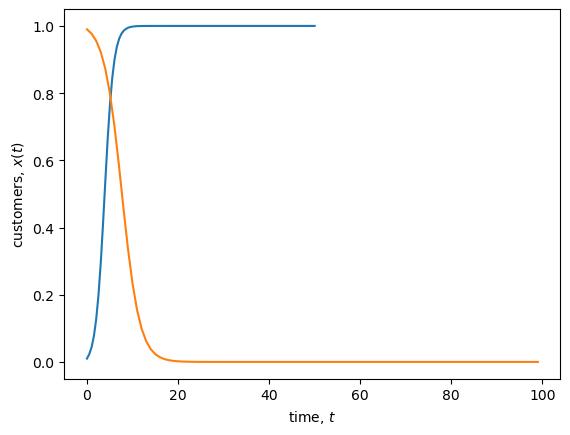

In [53]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)

# function that returns dx/dt
def model(x, t):
    p, q = 0.01, 1.0
    dxdt = p*(1-x) + q*x*(1-x)
    return dxdt

# initial condition
x0 = 0.01

# time points
t = np.linspace(0, 50, 100)

# solve ODE
x = odeint(model, x0, t)

# plot results
plt.plot(t, x, 1-x)
plt.xlabel('time, $t$')
plt.ylabel('customers, $x(t)$')
plt.show()

### Analytical solution

We will try to solve the following problem: Fix $p,q\in\mathbb{R}$ and $x_0\in[0,1]$. Find $x\in W([0,T];\mathbb{R})$ such that $\dot{x}(t)=p(1-x(t)) - qx(t)(1-x(t))$ and $x(0)\doteq x_0$.

In [57]:
import sympy as sym
from sympy import Function, dsolve, Derivative, symbols

t, p, q = sym.symbols('t, p, q')
x = sym.symbols('x', cls=Function)

# The first order differential equation dxdt(t) = p*x(t) + q*x(t)*(1-x(t))
eq = sym.Derivative(x(t), t) - p*(1 - x(t)) - q*x(t)*(1 - x(t))
sol = sym.dsolve(eq, x(t),).simplify(); sol #eq == 0

Eq(x(t), (-p*exp(C1*(p + q)) - q*exp(t*(p + q)))/(q*(exp(C1*(p + q)) - exp(t*(p + q)))))

In [58]:
from sympy import classify_ode

sym.classify_ode(Derivative(x(t), t) - p*(1 - x(t))*x(t) - q*x(t)*(1 - x(t))), x(t)

(('factorable',
  'separable',
  '1st_exact',
  'Bernoulli',
  '1st_power_series',
  'lie_group',
  'separable_Integral',
  '1st_exact_Integral',
  'Bernoulli_Integral'),
 x(t))

# Viability problem